<a href="https://colab.research.google.com/github/nando-cezar/pandora/blob/developer/pandora_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> EM-DAT will be used, which is a global database that records information about natural and technological disasters. It is maintained by the Disaster Epidemiology Research Center (CRED) at the Catholic University of Louvain, Belgium. EM-DAT provides data on the occurrence, impact and response to disasters since the beginning of the 20th century.

> Data analysis will be separated by category and continental regions, namely:

*   Dry
*   Flood
*   Extreme temperature
*   Mist
*   Storm







# Importing libraries


In [116]:
!pip3 install opencage
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [117]:
import pandas as pd
from google.colab import drive
from time import sleep
import warnings
import requests
import json
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import userdata
import requests_cache
from retry_requests import retry

from opencage.geocoder import OpenCageGeocode
import openmeteo_requests




warnings.simplefilter("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EM-DAT: Reading the file


> Restricting reading to the following columns: location, start date and end date.

In [118]:
df = pd.read_excel(f"{userdata.get('notebook_path')}/{userdata.get('file_path')}.xlsx", sheet_name=[0, "EM-DAT Data"], usecols='A, G, K, N, Z, AA, AB, AC, AD, AE')

# EM-DAT: File handling


> Performing row removal with NaN

In [119]:
_data_type = {'DisNo.': str, 'Disaster Subtype': str, 'Country': str, 'Location': str, 'Start Year': int, 'Start Month': int, 'Start Day': int, 'End Year': int, 'End Month': int, 'End Day': int}
df = df['EM-DAT Data'].fillna(0).astype(_data_type)

## EM-DAT: Data visualization without processing

In [120]:
display(df)

,DisNo.,Disaster Subtype,Country,Location,Start Year,Start Month,Start Day,End Year,End Month,End Day
0,2000-0019-BRA,Riverine flood,Brazil,"Rio de Janeiro, Rio de Janeiro; Sao Paulo, Sao...",2000,1,1,2000,1,6
1,2000-0456-BRA,Cold wave,Brazil,"Porto Alegre, Rio Grande Do Sul",2000,7,0,2000,7,0
2,2000-0590-BRA,Riverine flood,Brazil,"Recife, Pernambuco; Jaboatao Dos Guararapes, P...",2000,9,16,2000,9,18
3,2000-0809-BRA,Riverine flood,Brazil,"Belo Horizonte, Minas Gerais; Santos, Sao Paul...",2000,12,17,2000,12,26
4,2001-0213-BRA,Riverine flood,Brazil,"Cuiaba, Mato Grosso",2001,4,25,2001,4,26
...,...,...,...,...,...,...,...,...,...,...
79,2023-0434-BRA,"Flood, General",Brazil,"Matriz de Camaragibe, Alagoas; Marechal Deodor...",2023,7,10,2023,7,14
80,2023-0603-BRA,Tropical cyclone,Brazil,"Muçum, Rio Grande do Sul; Roca Sales, Rio Gran...",2023,9,1,2023,9,4
81,2023-0663-BRA,"Flood, General",Brazil,"Rio do Sul, Santa Catarina; Tubarão, Santa Cat...",2023,10,10,2023,10,10
82,2023-0747-BRA,Severe weather,Brazil,"Porto Alegre, Rio Grande do Sul; Balneário Cam...",2023,11,11,2023,11,14


# Treatment: Algorithms for data processing and structure assembly

> Algorithm for processing data (Formatting date for the api model)



In [121]:
def date_format_API(date):
  return "-".join([str(int(item)).zfill(2) if isinstance(item, float) else str(item).zfill(2) for item in date])

> Algorithm for boxplot graph plating

In [139]:
def generate_bsplot(dataFrame, xv, yv, xlabel, ylabel, title, width=25, heigth=10, boxplot_width=0.5):

    plt.figure(figsize=(width, heigth))

    sns.boxplot(
        data=dataFrame,
        x=xv,
        y=yv
    )

    sns.stripplot(
        data=dataFrame,
        x=xv,
        y=yv
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()


> Algorithm for switch value

In [123]:
def switch_value(source, offset, target):
    return target if source == offset else source

# OPEN CAGE GEOCODE: Load latitude and longitude information from API

> Algorithm for processing data (Search latitude and longitude from location)

In [124]:
geocoder = OpenCageGeocode(userdata.get('api_key_opencage_geocode'))

def search_location(query):
    response = geocoder.geocode(query)
    return response

> Getting information and formatting dataframe


In [125]:
_locale_structure = []

def get_location_info(country, location):
    location_join = ", ".join([location, country])

    result = search_location(query=location_join)

    if result:
        location_info = {
            'Location': result[0]["formatted"],
            'Latitude': result[0]["geometry"]["lat"],
            'Longitude': result[0]["geometry"]["lng"],
            'Timezone': result[0]["annotations"]["timezone"]["name"]
        }
        return location_info

    return None

def process_location_info(infos):
    start_day = switch_value(infos['Start Day'], 0, 1)
    end_day = switch_value(infos['End Day'], 0, 30)
    start_month = switch_value(infos['Start Month'], 0, 1)
    end_month = switch_value(infos['End Month'], 0, 12)
    start_date = [infos['Start Year'], start_month, start_day]
    end_date = [infos['End Year'], end_month, end_day]

    rdf = infos["Location"].split(';')

    if rdf:
        for location in rdf:
            location_info = get_location_info(infos["Country"], location.strip())
            if location_info and location_info["Location"] != infos["Country"]:
                location_info.update(
                    {
                        'DisNo.': infos['DisNo.'],
                        'Disaster Subtype': infos['Disaster Subtype'],
                        'Start Date': start_date,
                        'End Date': end_date
                        }
                    )
                _locale_structure.append(location_info)

for _, infos in df.iterrows():
    process_location_info(infos)

## OPEN CAGE GEOCODE: Data visualization without processing

In [126]:
_data_type = {'Location': str, 'Latitude': str, 'Longitude': str, 'DisNo.': str, 'Disaster Subtype': str, 'Start Date': object, 'End Date': object}
df = pd.DataFrame(_locale_structure).astype(_data_type)
display(df)

,Location,Latitude,Longitude,Timezone,DisNo.,Disaster Subtype,Start Date,End Date
0,"Rio de Janeiro, Região Metropolitana do Rio de...",-22.9110137,-43.2093727,America/Sao_Paulo,2000-0019-BRA,Riverine flood,"[2000, 1, 1]","[2000, 1, 6]"
1,"São Paulo, Região Metropolitana de São Paulo, ...",-23.5506507,-46.6333824,America/Sao_Paulo,2000-0019-BRA,Riverine flood,"[2000, 1, 1]","[2000, 1, 6]"
2,"Campos do Jordão, Região Metropolitana do Vale...",-22.738299,-45.5903769,America/Sao_Paulo,2000-0019-BRA,Riverine flood,"[2000, 1, 1]","[2000, 1, 6]"
3,"Volta Redonda, Região Geográfica Intermediária...",-22.521856,-44.1040128,America/Sao_Paulo,2000-0019-BRA,Riverine flood,"[2000, 1, 1]","[2000, 1, 6]"
4,"Barra Mansa, Região Geográfica Intermediária d...",-22.5394843,-44.1735129,America/Sao_Paulo,2000-0019-BRA,Riverine flood,"[2000, 1, 1]","[2000, 1, 6]"
...,...,...,...,...,...,...,...,...
380,"Lajeado, Região Geográfica Intermediária de Sa...",-29.4671522,-51.9624046,America/Sao_Paulo,2023-0777-BRA,"Flood, General","[2023, 11, 13]","[2023, 11, 19]"
381,"Muçum, Região Geográfica Intermediária de Sant...",-29.1666714,-51.8747726,America/Sao_Paulo,2023-0777-BRA,"Flood, General","[2023, 11, 13]","[2023, 11, 19]"
382,"Roca Sales, Região Geográfica Intermediária de...",-29.2872555,-51.8724318,America/Sao_Paulo,2023-0777-BRA,"Flood, General","[2023, 11, 13]","[2023, 11, 19]"
383,"Santa Tereza, Região Geográfica Intermediária ...",-29.1697808,-51.7363155,America/Sao_Paulo,2023-0777-BRA,"Flood, General","[2023, 11, 13]","[2023, 11, 19]"


#OPEN-METEO: Load weather information from API



> Algorithm for processing data (Search weather from latitude and longitude)


In [127]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def search_info_weather(id, disaster_subtype, latitude, longitude, start_date, end_date, timezone):
    start_date = date_format_API(date=start_date)
    end_date = date_format_API(date=end_date)
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "apparent_temperature_max",
            "apparent_temperature_min",
            "apparent_temperature_mean",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": timezone,
	    "models": [
            "best_match"
            ]
    }

    responses = openmeteo.weather_api(userdata.get('api_url_openmeteo'), params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    variables = [daily.Variables(i).ValuesAsNumpy() for i in range(15)]
    variable_names = [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "apparent_temperature_mean",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]


    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s"),
        end=pd.to_datetime(daily.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}

    daily_data["id"] = id
    daily_data["disaster_subtype"] = disaster_subtype
    daily_data["latitude"] = response.Latitude()
    daily_data["longitude"] = response.Longitude()

    for name, values in zip(variable_names, variables):
        daily_data[name] = values

    return daily_data

> Getting information and formatting dataframe

In [128]:
_weather_structure = []
for i, infos in df.iterrows():
  _info = search_info_weather(
      id=infos['DisNo.'],
      disaster_subtype=infos['Disaster Subtype'],
      latitude=infos['Latitude'],
      longitude=infos['Longitude'],
      start_date=infos['Start Date'],
      end_date=infos['End Date'],
      timezone=infos['Timezone']
      )
  _weather_structure.append(_info)

##OPEN-METEO: Data visualization without processing

In [129]:
df = pd.DataFrame(data = _weather_structure)
display(df)

,date,id,disaster_subtype,latitude,longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,"DatetimeIndex(['2000-01-01 03:00:00', '2000-01...",2000-0019-BRA,Riverine flood,-22.882250,-43.076111,"[28.1365, 27.436499, 27.8365, 32.286503, 33.18...","[23.8865, 23.036499, 22.186499, 23.036499, 22....","[25.744833, 24.692749, 24.721916, 26.861498, 2...","[32.57379, 31.710709, 32.213512, 37.36607, 38....","[27.435997, 26.685484, 25.922243, 26.881165, 2...","[30.088766, 28.732773, 29.388603, 31.146456, 3...","[15.400001, 69.5, 28.199997, 0.0, 0.1, 0.0]","[15.400001, 69.5, 28.199997, 0.0, 0.1, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[17.0, 22.0, 18.0, 0.0, 1.0, 0.0]","[11.367109, 14.05845, 9.387651, 14.04, 15.1114...","[31.68, 46.44, 50.76, 36.719997, 30.599998, 23...","[43.13236, 333.435, 64.45285, 32.95635, 34.695...","[10.1, 8.84, 8.04, 15.58, 27.49, 26.67]","[2.3322668, 2.0266016, 1.8361936, 3.614346, 6...."
1,"DatetimeIndex(['2000-01-01 03:00:00', '2000-01...",2000-0019-BRA,Riverine flood,-23.585238,-46.659637,"[23.637, 21.337, 20.987, 23.337, 24.337, 26.337]","[19.087, 18.187, 17.987, 18.187, 19.737, 18.887]","[20.587, 19.532835, 19.1745, 20.42658, 21.1911...","[26.206207, 23.110186, 21.760677, 25.405865, 2...","[20.647556, 18.85355, 18.814064, 19.851942, 20...","[22.337517, 20.729143, 20.142225, 22.220366, 2...","[16.5, 14.1, 12.300001, 42.899998, 23.699999, ...","[16.5, 14.1, 12.300001, 42.899998, 23.699999, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[17.0, 16.0, 19.0, 24.0, 20.0, 7.0]","[18.782204, 20.60823, 17.10284, 16.311613, 19....","[38.519997, 43.199997, 35.28, 56.88, 43.199997...","[248.94632, 166.50171, 143.7712, 359.79462, 34...","[9.39, 9.3, 11.49, 6.7, 7.99, 22.03]","[1.7998751, 1.6334125, 1.9992855, 1.4608076, 1..."
2,"DatetimeIndex(['2000-01-01 03:00:00', '2000-01...",2000-0019-BRA,Riverine flood,-22.741652,-45.515106,"[20.005001, 18.305, 16.705, 19.555, 23.455, 23...","[15.855, 15.705, 15.155001, 15.905001, 15.555,...","[17.467499, 16.5675, 15.802917, 17.136251, 18....","[20.787561, 19.97695, 17.796795, 19.354843, 24...","[16.683985, 17.014887, 15.820475, 15.265488, 1...","[18.402506, 17.821163, 16.64786, 17.070908, 19...","[38.100002, 90.2, 176.2, 29.799997, 9.0, 17.09...","[38.100002, 90.2, 176.2, 29.799997, 9.0, 17.09...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[24.0, 24.0, 24.0, 19.0, 8.0, 14.0]","[12.758432, 7.5942082, 12.979984, 17.643673, 1...","[34.2, 37.079998, 57.96, 79.56, 55.44, 30.239998]","[349.22595, 341.50568, 24.722775, 358.5939, 34...","[9.84, 4.76, 2.53, 9.07, 20.46, 21.52]","[1.8508347, 1.0186446, 0.6559789, 1.6559734, 3..."
3,"DatetimeIndex(['2000-01-01 03:00:00', '2000-01...",2000-0019-BRA,Riverine flood,-22.530756,-44.066376,"[24.918001, 25.018, 24.368, 26.268, 31.018, 30...","[21.168001, 21.368, 20.868, 21.368, 18.918001,...","[22.863836, 22.62008, 22.384668, 23.290916, 24...","[28.152119, 28.690392, 27.387468, 28.994804, 3...","[23.728838, 23.259632, 22.954874, 23.09392, 20...","[25.90302, 25.541254, 25.23567, 25.573156, 27....","[14.999999, 67.399994, 35.300003, 2.8999999, 1...","[14.999999, 67.399994, 35.300003, 2.8999999, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[21.0, 24.0, 24.0, 10.0, 3.0, 2.0]","[13.556282, 13.084402, 13.138765, 17.935081, 1...","[30.960001, 43.56, 55.44, 46.44, 37.8, 21.24]","[1.101687, 12.383601, 28.584646, 355.9417, 351...","[8.09, 8.16, 6.3, 11.22, 24.65, 24.35]","[1.7527972, 1.8091378, 1.4700608, 2.5233495, 5..."
4,"DatetimeIndex(['2000-01-01 03:00:00', '2000-01...",2000-0019-BRA,Riverine flood,-22.530756,-44.159760,"[25.199, 25.299, 24.499, 26.348999, 31.449, 31...","[21.299, 21.249, 20.899, 21.649, 19.649, 20.299]","[23.053167, 22.726084, 22.505247, 23.469833, 2...","[28.953861, 29.641708, 28.669212, 29.4110

## Reorganization of daily information structure

In [130]:
columns_to_explode = [
    'date',
    'temperature_2m_max',
    'temperature_2m_min',
    'temperature_2m_mean',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'apparent_temperature_mean',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

df = df.explode(columns_to_explode)


##OPEN-METEO: Data visualization daily information

In [131]:
_data_type = {
    'date': object,
    'id': str,
    'latitude': str,
    'longitude': str,
    'temperature_2m_max': float,
    'temperature_2m_min': float,
    'temperature_2m_mean': float,
    'apparent_temperature_max': float,
    'apparent_temperature_min': float,
    'apparent_temperature_mean': float,
    'precipitation_sum': float,
    'rain_sum': float,
    'snowfall_sum': float,
    'precipitation_hours': float,
    'wind_speed_10m_max': float,
    'wind_gusts_10m_max': float,
    'wind_direction_10m_dominant': float,
    'shortwave_radiation_sum': float,
    'et0_fao_evapotranspiration': float
}

df = df.astype(_data_type)
display(df)

,date,id,disaster_subtype,latitude,longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2000-01-01 03:00:00,2000-0019-BRA,Riverine flood,-22.88224983215332,-43.07611083984375,28.136499,23.886499,25.744833,32.573792,27.435997,30.088766,15.400001,15.400001,0.0,17.0,11.367109,31.680000,43.132359,10.100000,2.332267
0,2000-01-02 03:00:00,2000-0019-BRA,Riverine flood,-22.88224983215332,-43.07611083984375,27.436499,23.036499,24.692749,31.710709,26.685484,28.732773,69.500000,69.500000,0.0,22.0,14.058450,46.439999,333.434998,8.840000,2.026602
0,2000-01-03 03:00:00,2000-0019-BRA,Riverine flood,-22.88224983215332,-43.07611083984375,27.836500,22.186499,24.721916,32.213512,25.922243,29.388603,28.199997,28.199997,0.0,18.0,9.387651,50.759998,64.452850,8.040000,1.836194
0,2000-01-04 03:00:00,2000-0019-BRA,Riverine flood,-22.88224983215332,-43.07611083984375,32.286503,23.036499,26.861498,37.366070,26.881165,31.146456,0.000000,0.000000,0.0,0.0,14.040000,36.719997,32.956348,15.580000,3.614346
0,2000-01-05 03:00:00,2000-0019-BRA,Riverine flood,-22.88224983215332,-43.07611083984375,33.186501,22.686499,28.138582,38.628422,26.335186,32.509533,0.100000,0.100000,0.0,1.0,15.111424,30.599998,34.695259,27.490000,6.028115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,2023-11-15 03:00:00,2023-0777-BRA,"Flood, General",-29.771530151367188,-51.8466796875,28.215500,17.365501,22.409254,32.389717,18.984413,25.467110,29.100002,29.100002,0.0,10.0,18.374111,46.799999,5.922284,17.469999,3.273397
384,2023-11-16 03:00:00,2023-0777-BRA,"Flood, General",-29.771530151367188,-51.8466796875,25.315500,20.615501,22.490501,28.674568,22.832615,25.899551,8.200000,8.200000,0.0,12.0,11.212135,25.919998,87.180984,9.460000,1.845716
384,2023-11-17 03:00:00,2023-0777-BRA,"Flood, General",-29.771530151367188,-51.8466796875,24.815500,18.365501,21.507170,27.780689,18.749744,23.586958,66.599991,66.599991,0.0,12.0,17.414476,34.200001,100.935425,8.290000,1.685927
384,2023-11-18 03:00:00,2023-0777-BRA,"Flood, General",-29.771530151367188,-51.8466796875,25.165501,19.115501,22.386332,26.297392,20.004423,23.897018,16.400000,16.400000,0.0,12.0,22.267679,43.919998,339.638336,13.100000,2.722807


#Data analysis - BOX PLOT


### Data visualization with processing

In [132]:
df_gen=df

> Temperature

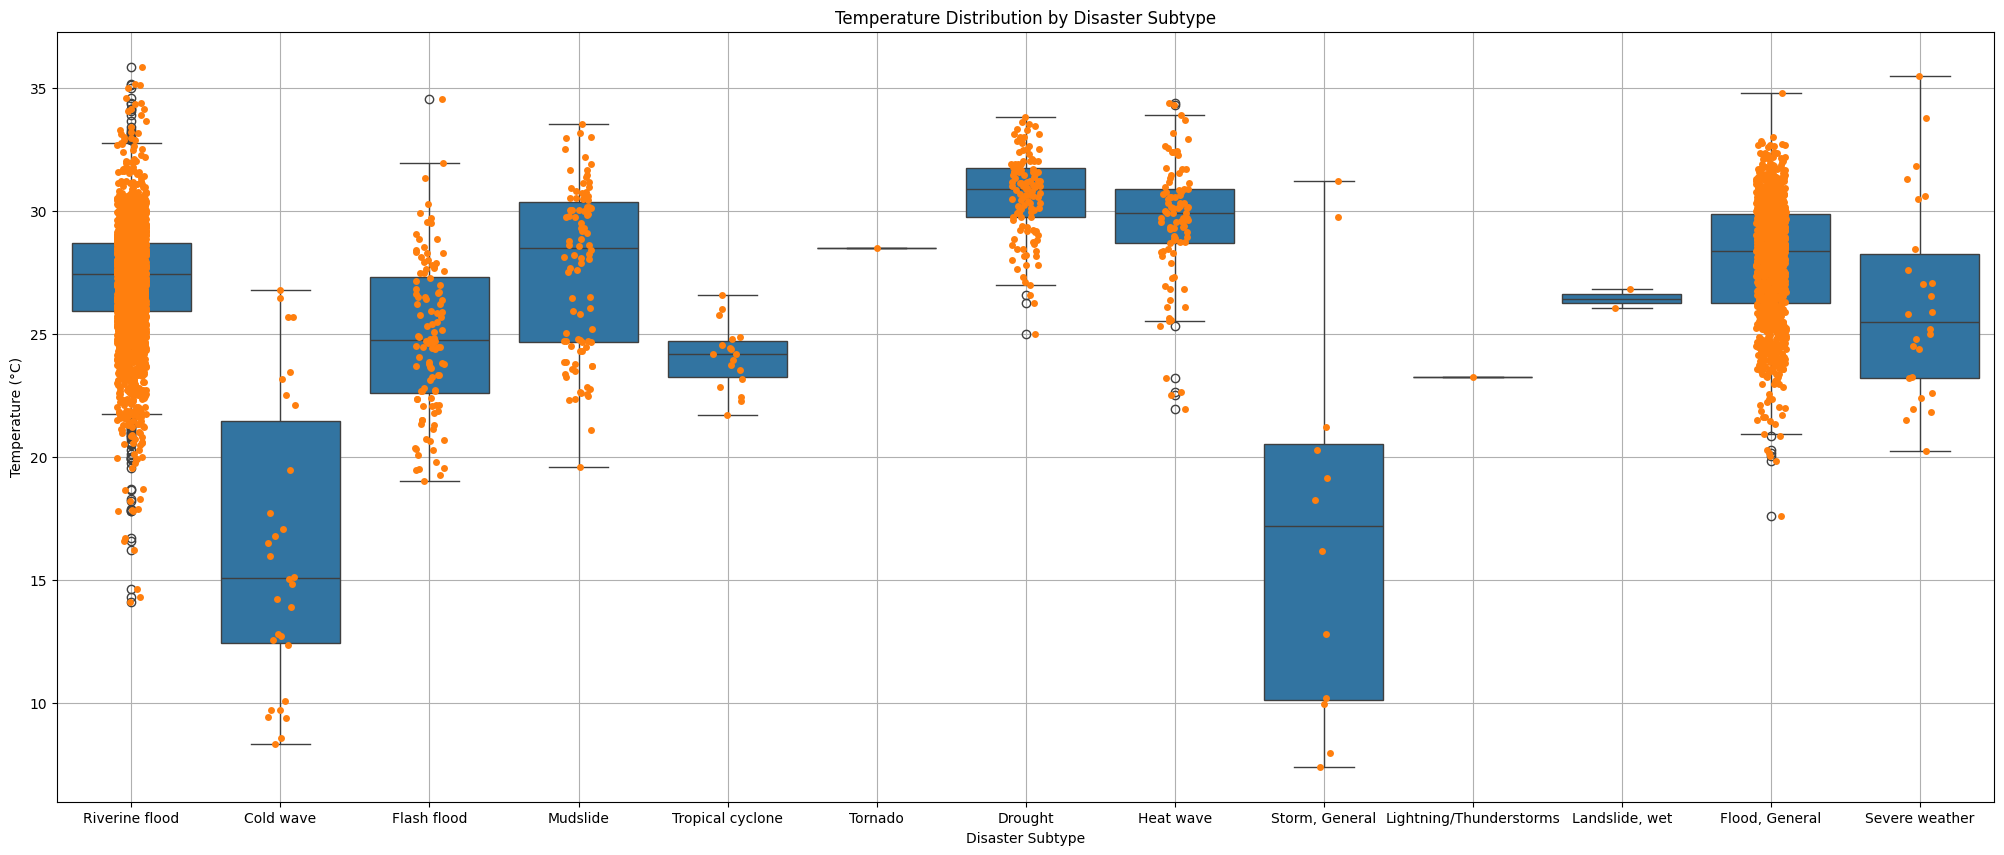

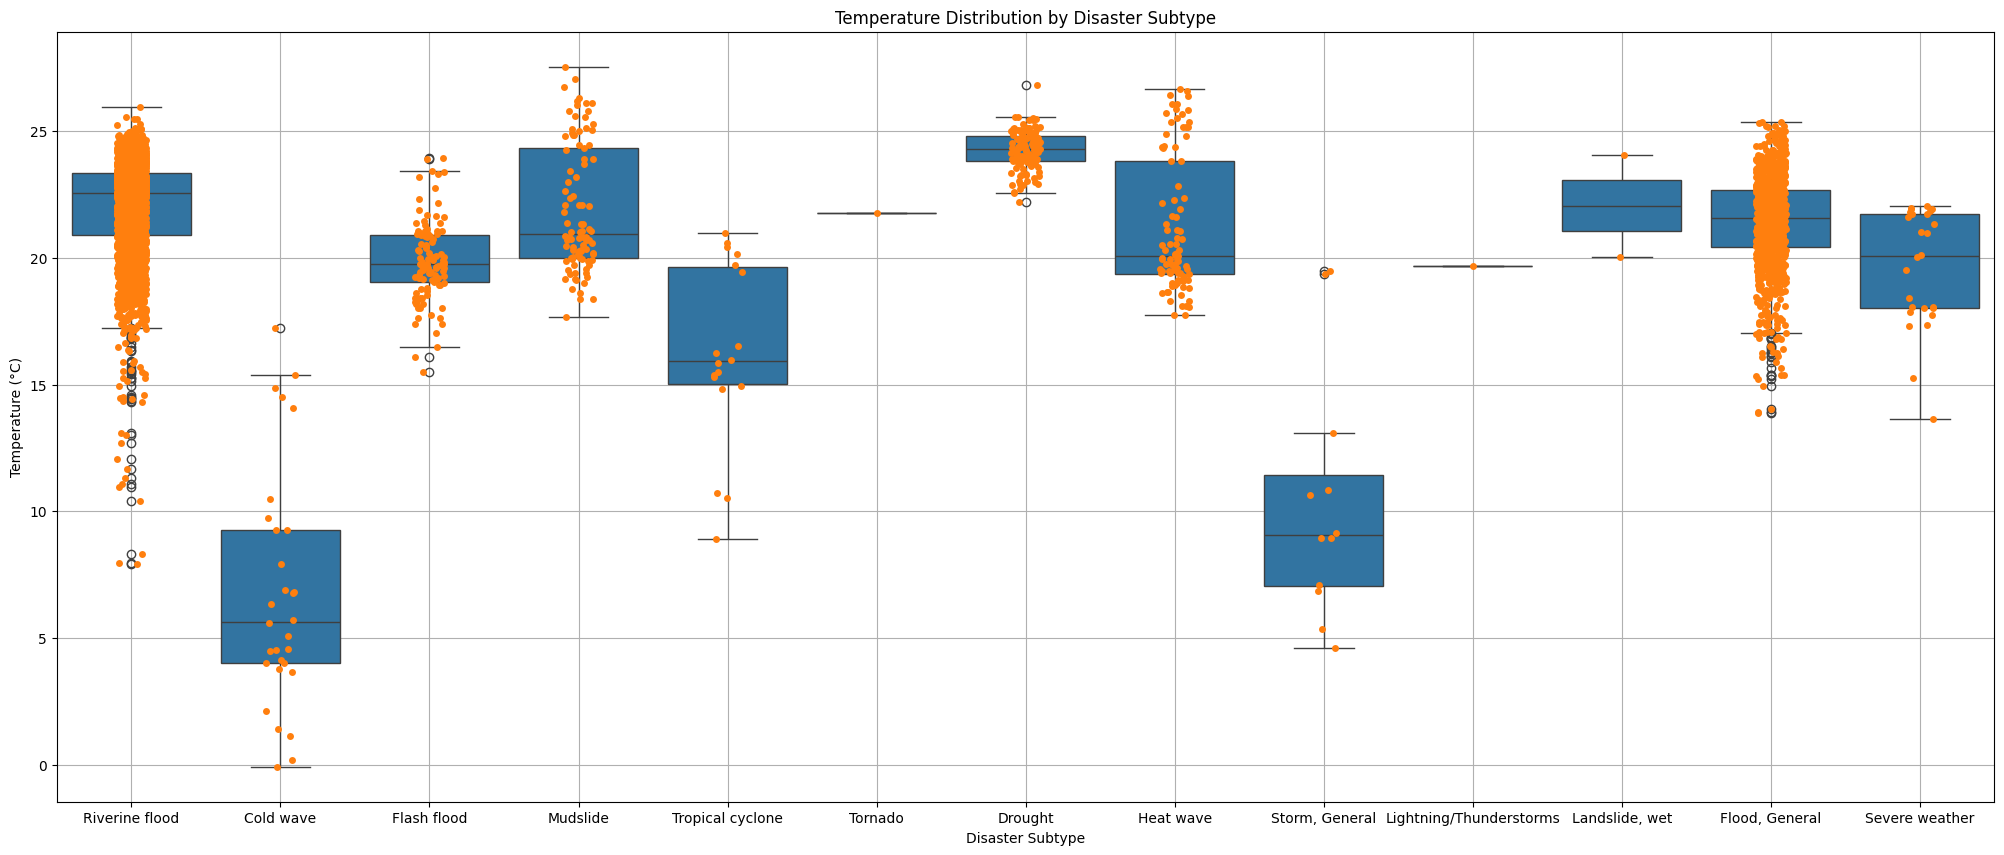

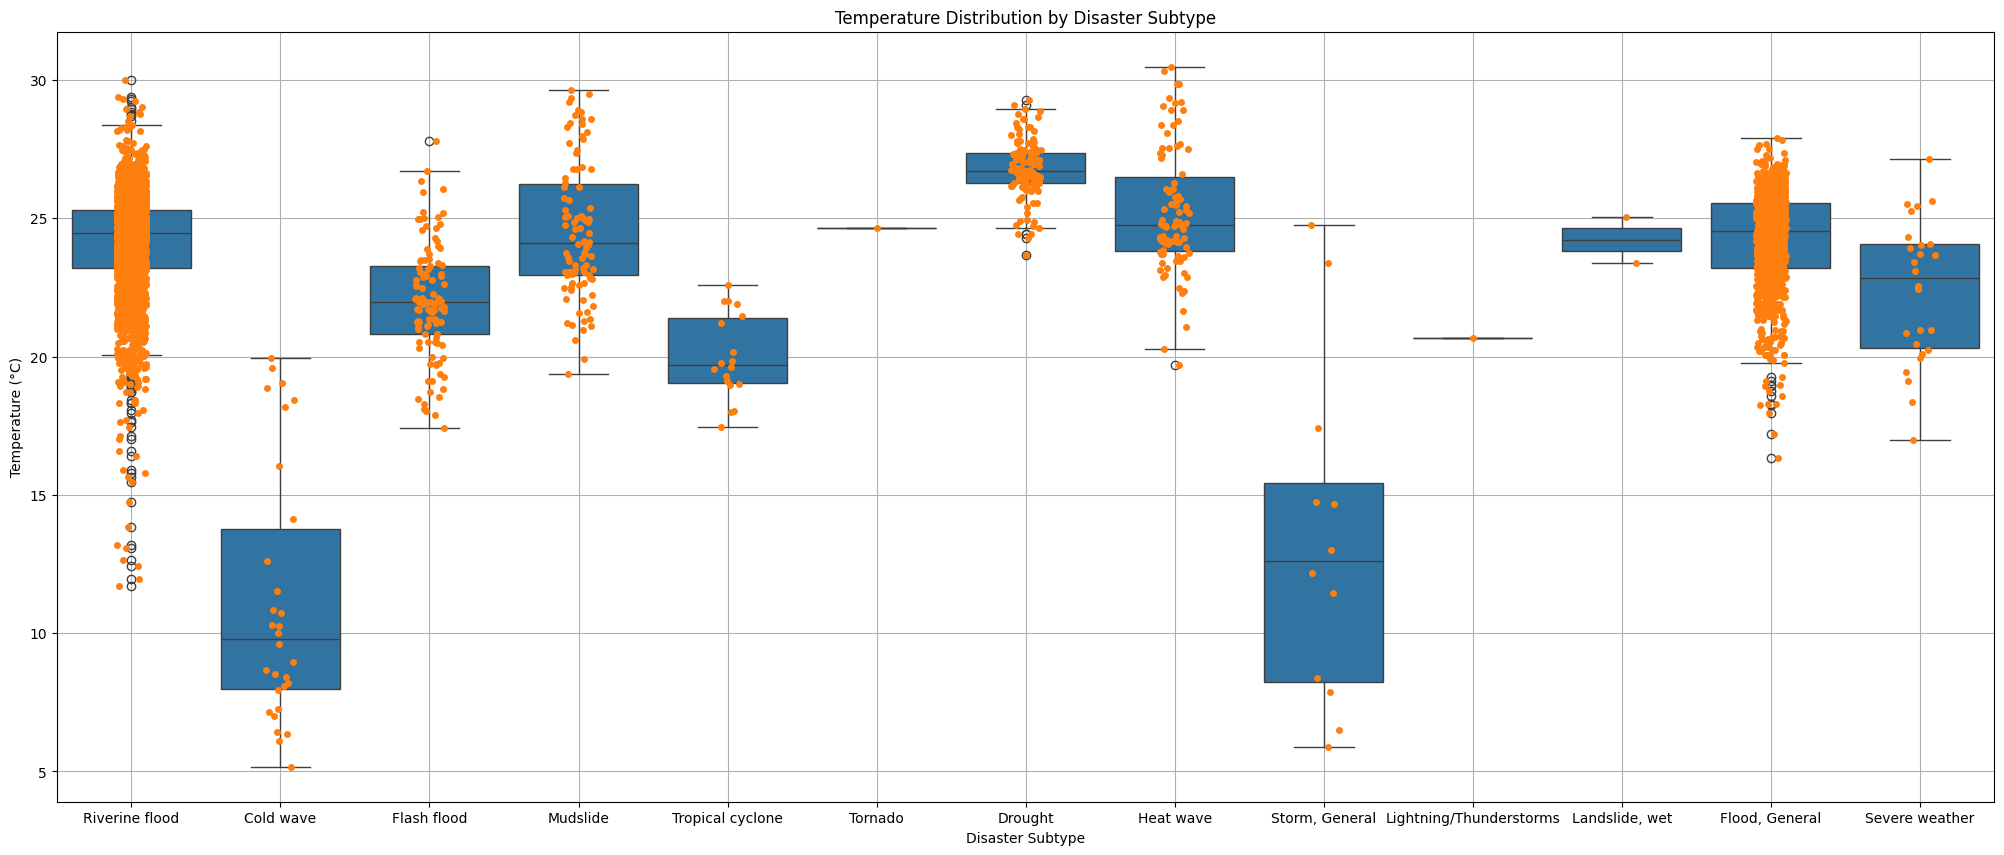

In [141]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="temperature_2m_max",
    xlabel="Disaster Subtype",
    ylabel="Temperature (°C)",
    title="Temperature Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="temperature_2m_min",
    xlabel="Disaster Subtype",
    ylabel="Temperature (°C)",
    title="Temperature Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="temperature_2m_mean",
    xlabel="Disaster Subtype",
    ylabel="Temperature (°C)",
    title="Temperature Distribution by Disaster Subtype"
    )

> Apparent Temperature

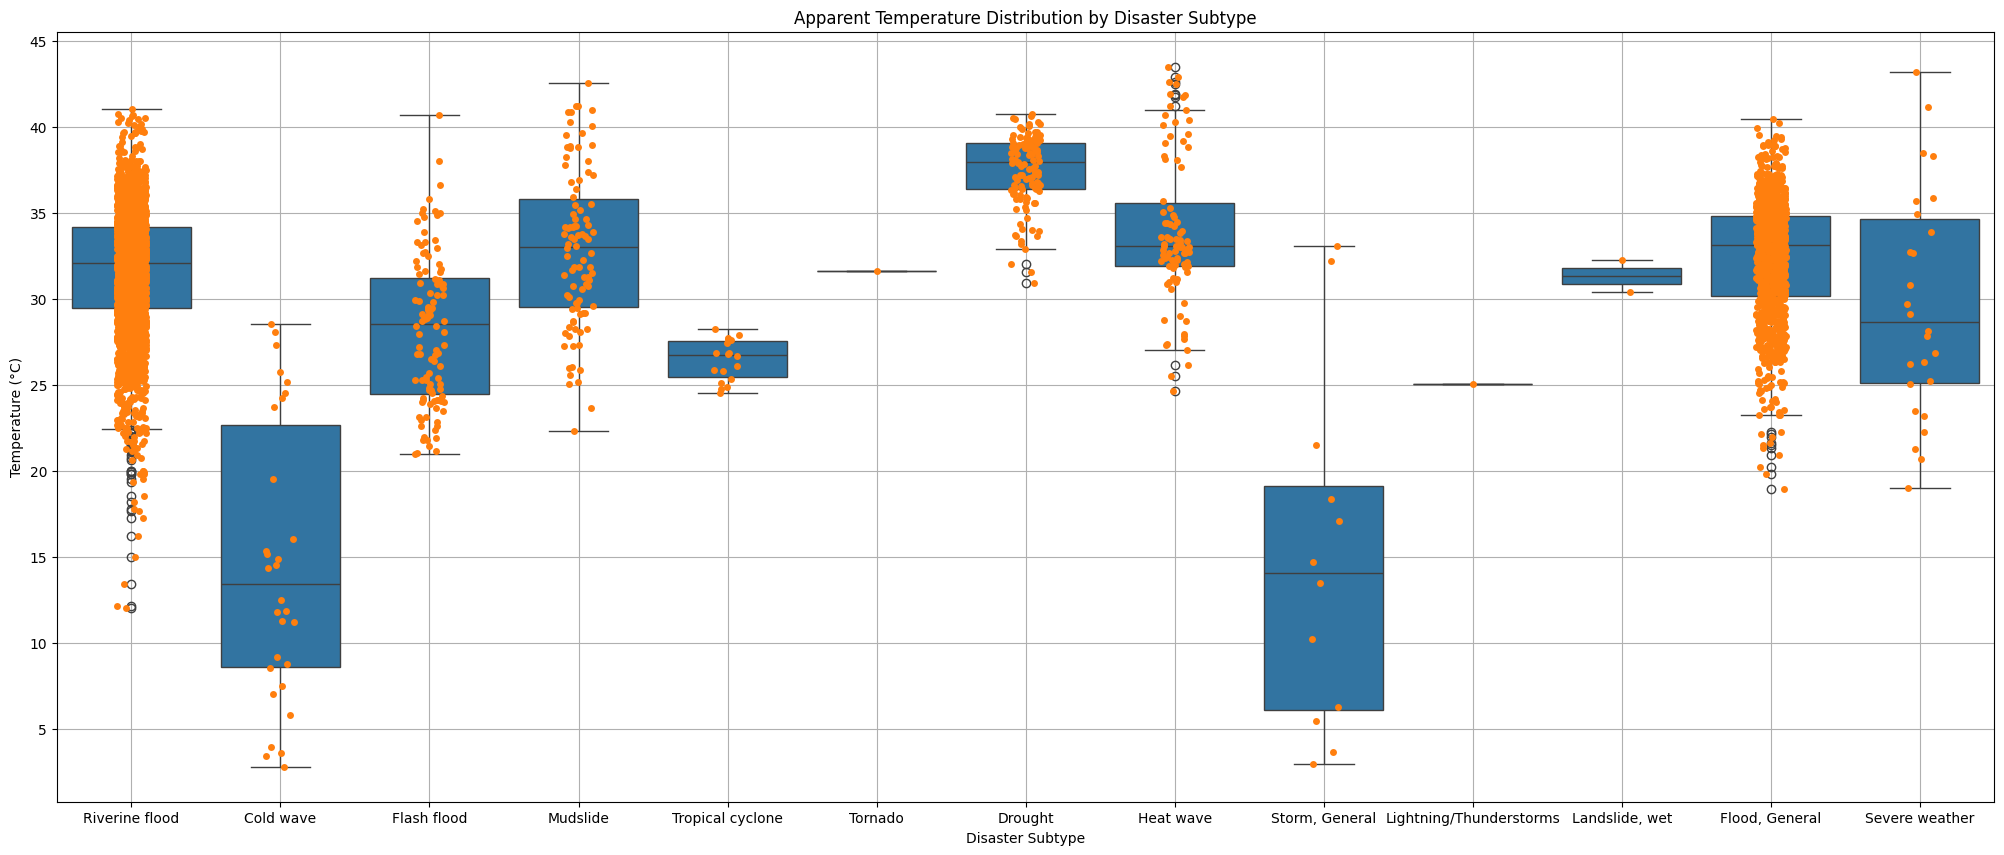

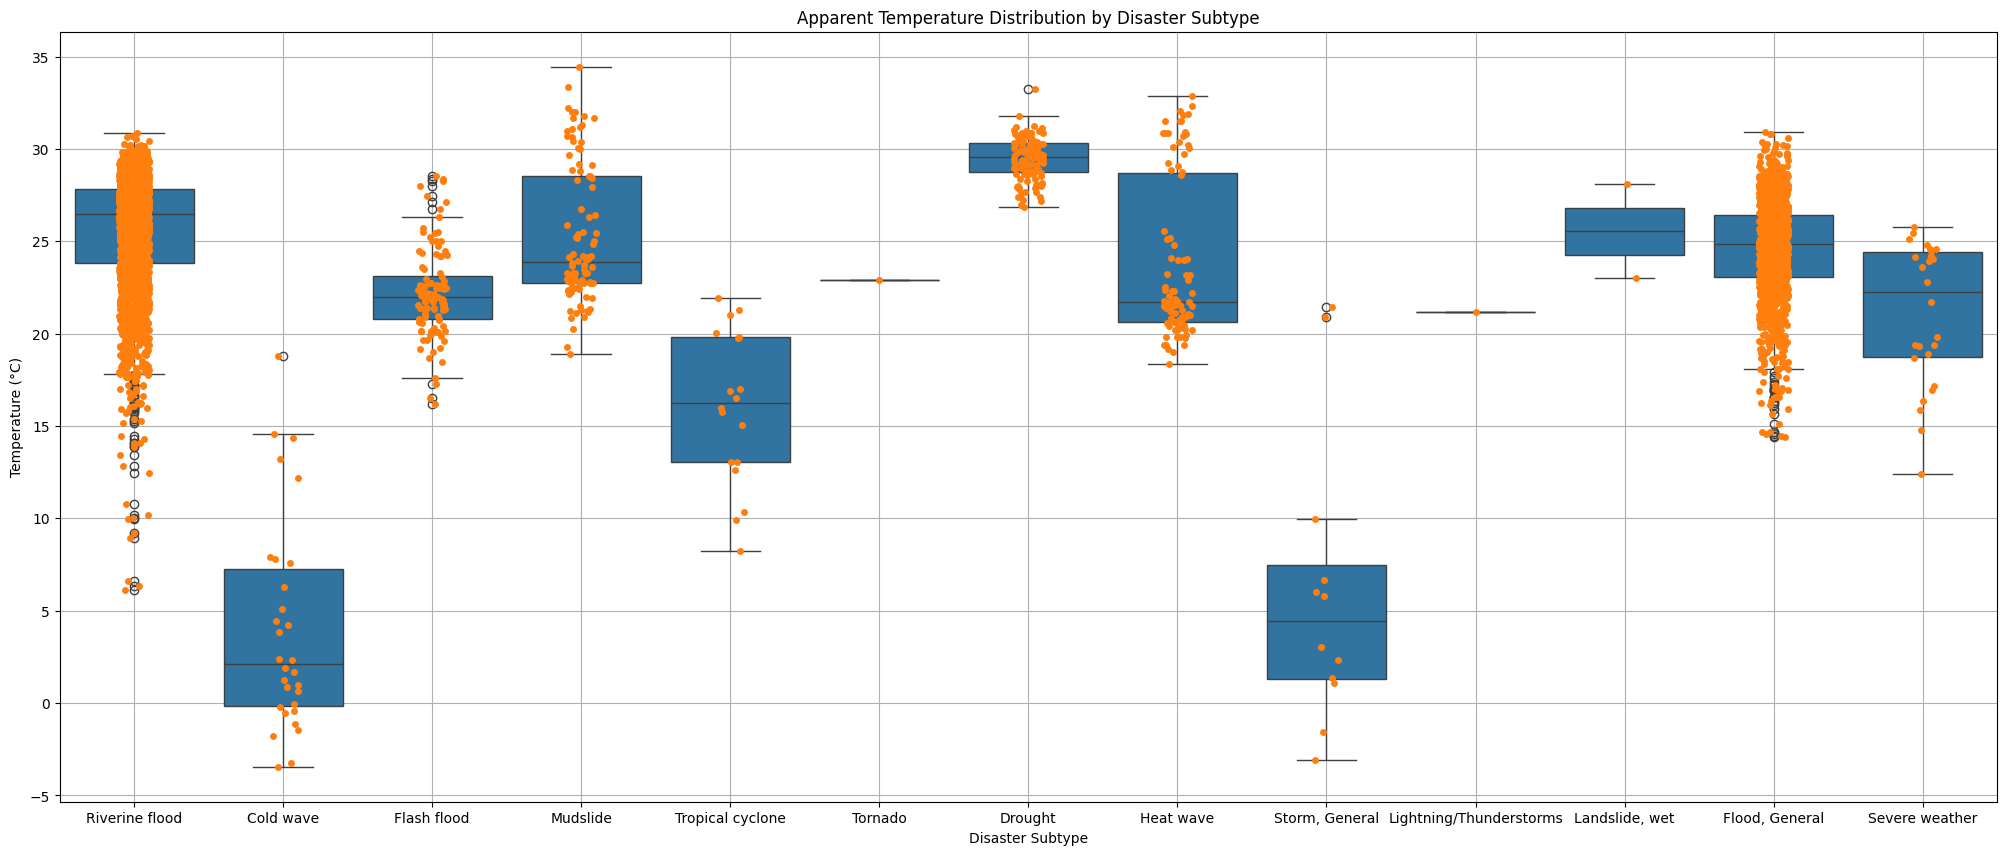

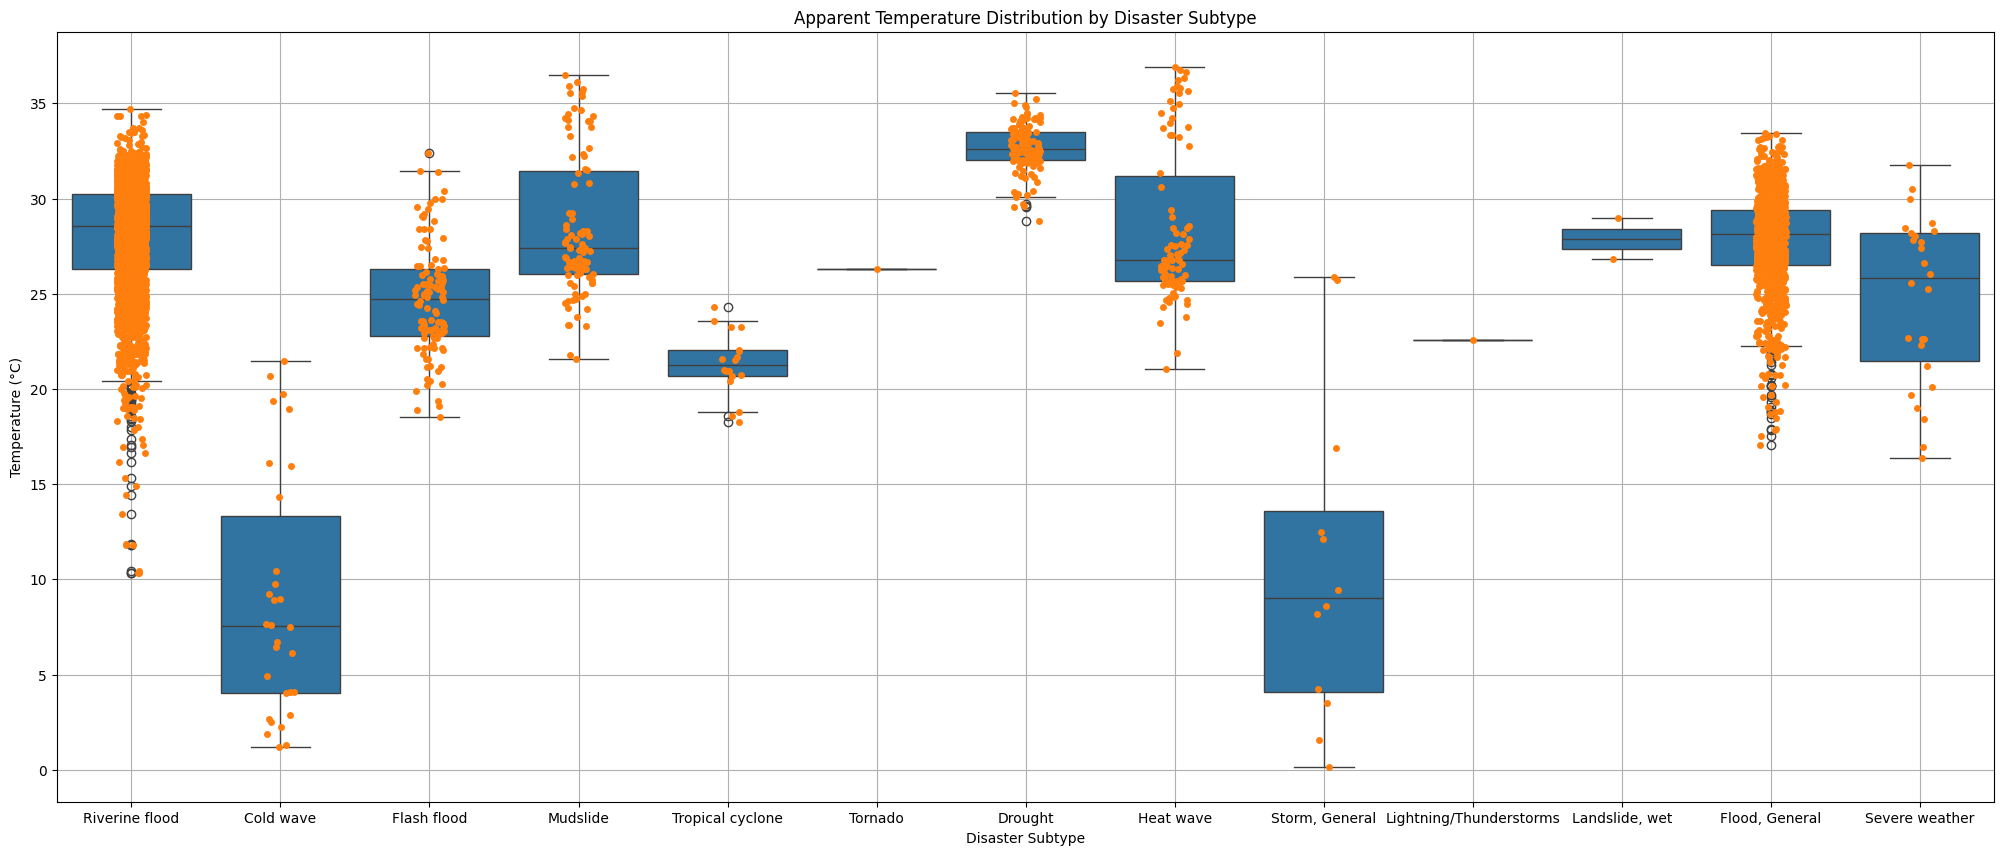

In [142]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="apparent_temperature_max",
    xlabel="Disaster Subtype",
    ylabel="Temperature (°C)",
    title="Apparent Temperature Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="apparent_temperature_min",
    xlabel="Disaster Subtype",
    ylabel="Temperature (°C)",
    title="Apparent Temperature Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="apparent_temperature_mean",
    xlabel="Disaster Subtype",
    ylabel="Temperature (°C)",
    title="Apparent Temperature Distribution by Disaster Subtype"
    )

> Precipitation and rain

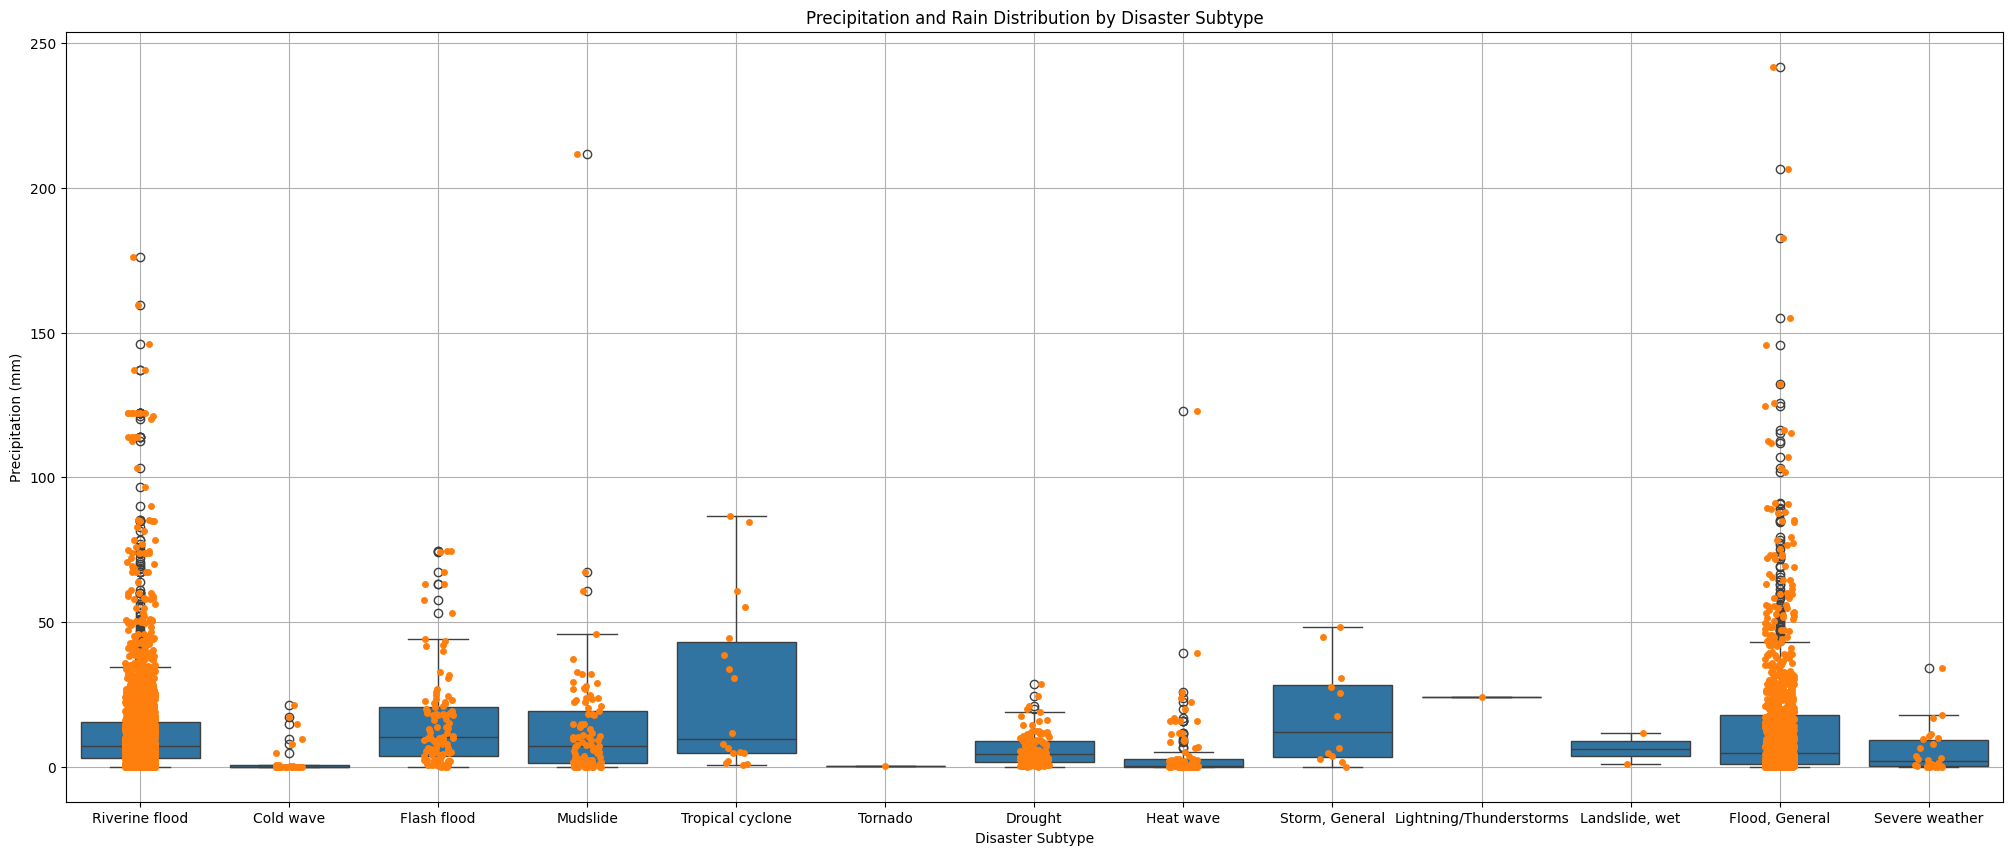

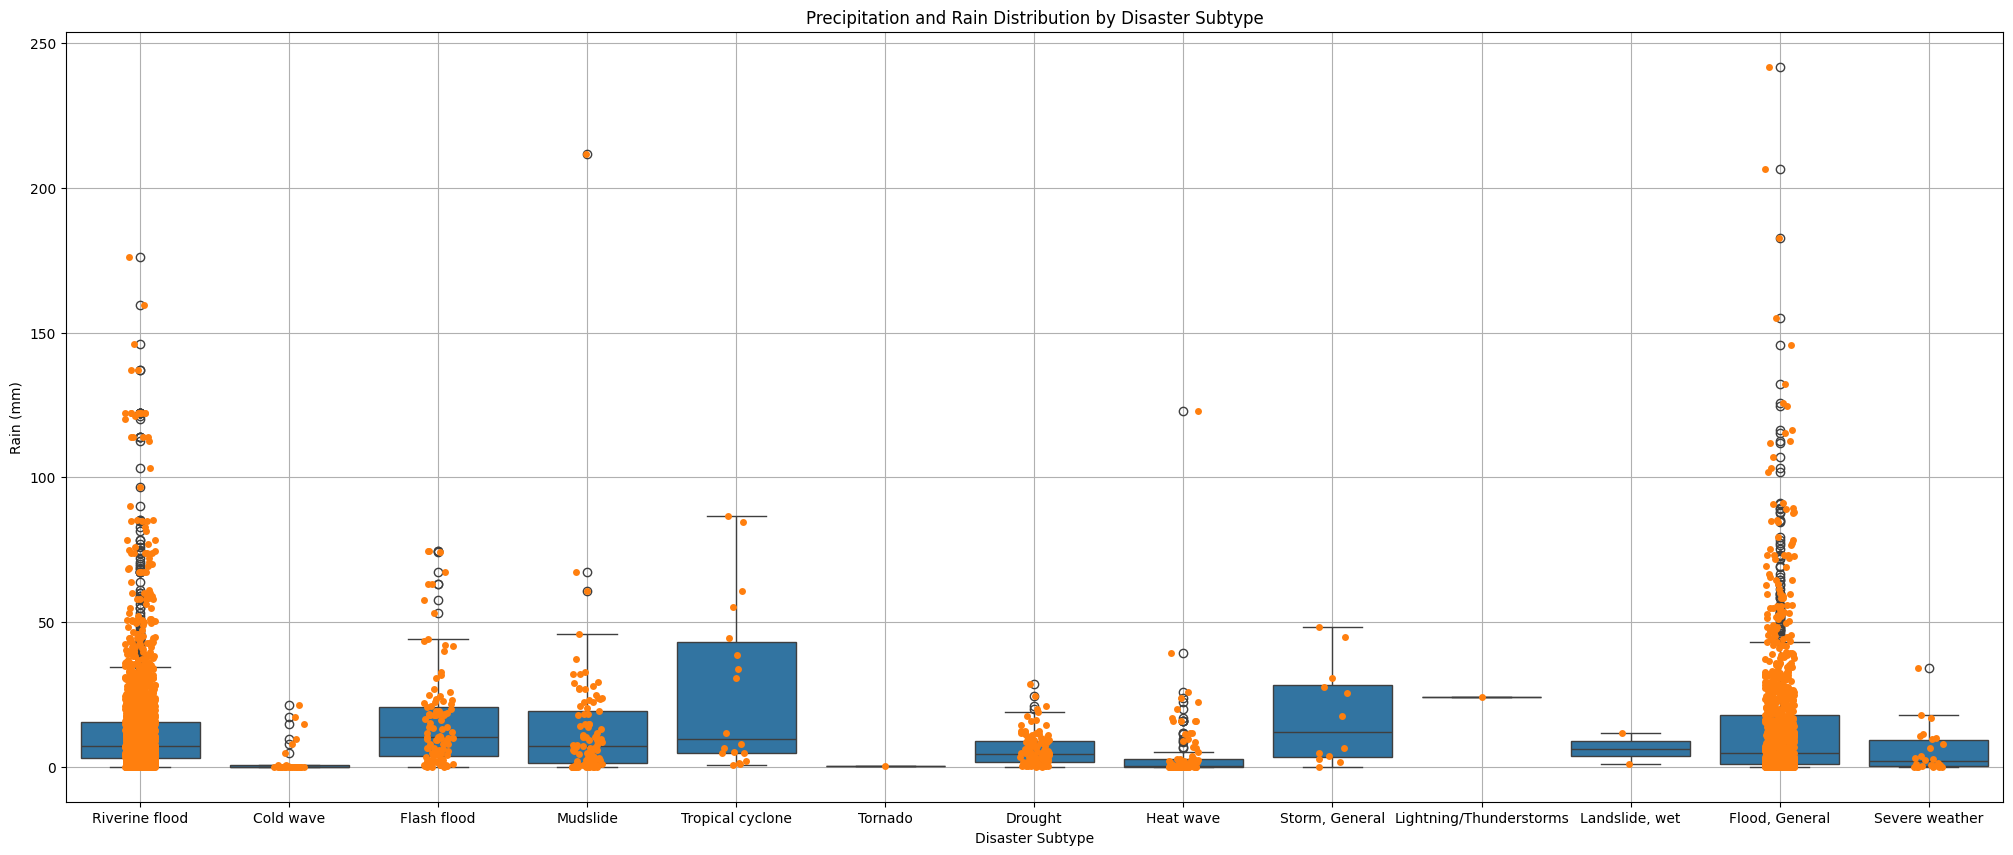

In [146]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="precipitation_sum",
    xlabel="Disaster Subtype",
    ylabel="Precipitation (mm)",
    title="Precipitation and Rain Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="rain_sum",
    xlabel="Disaster Subtype",
    ylabel="Rain (mm)",
    title="Precipitation and Rain Distribution by Disaster Subtype"
    )

> Snowfall

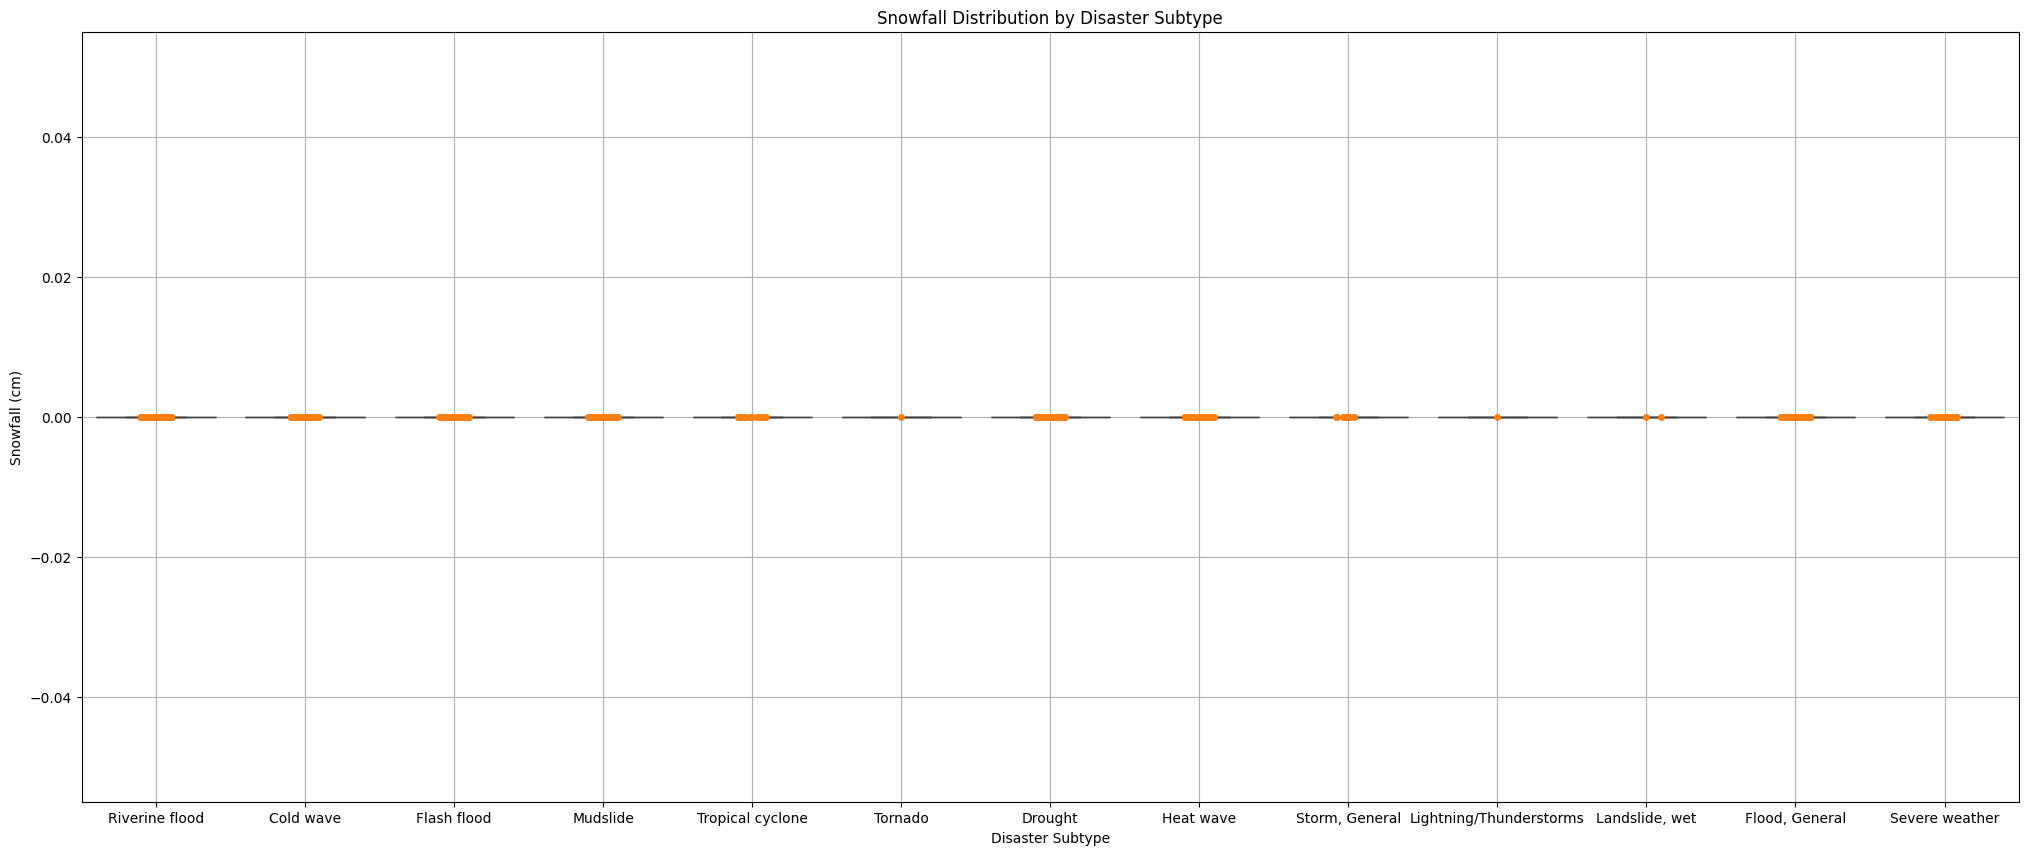

In [145]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="snowfall_sum",
    xlabel="Disaster Subtype",
    ylabel="Snowfall (cm)",
    title="Snowfall Distribution by Disaster Subtype"
    )

> Precipitation (h)

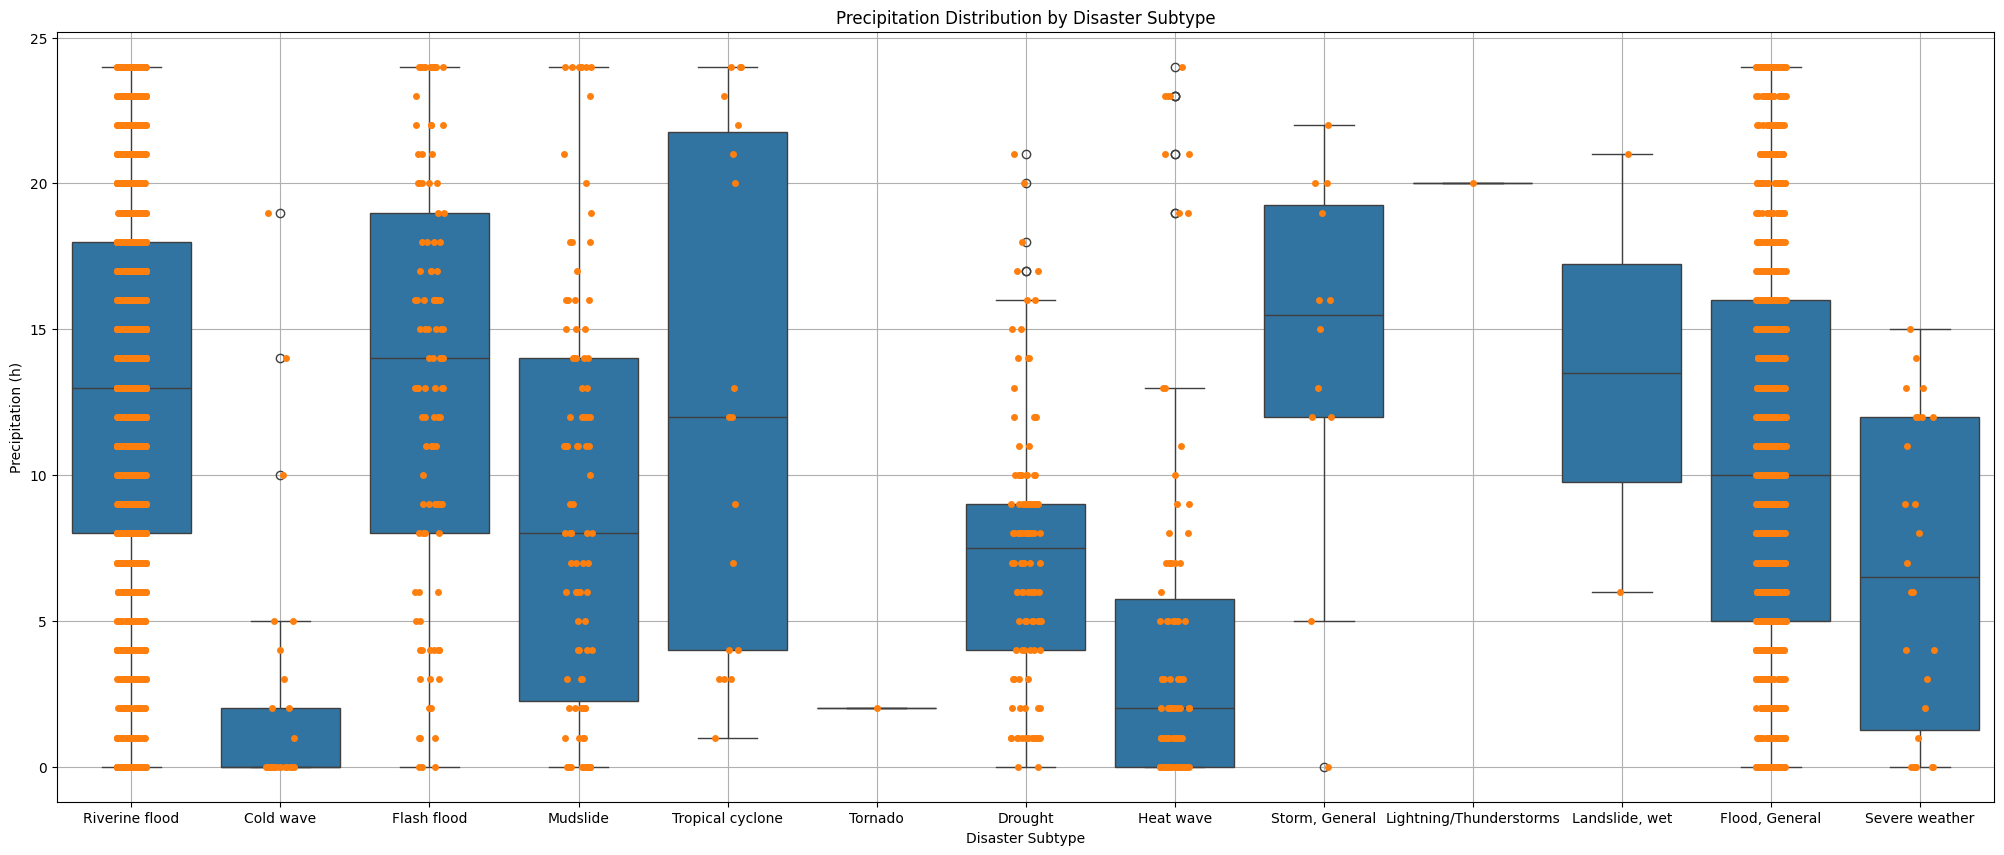

In [147]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="precipitation_hours",
    xlabel="Disaster Subtype",
    ylabel="Precipitation (h)",
    title="Precipitation Distribution by Disaster Subtype"
    )

> Wind speed 10m

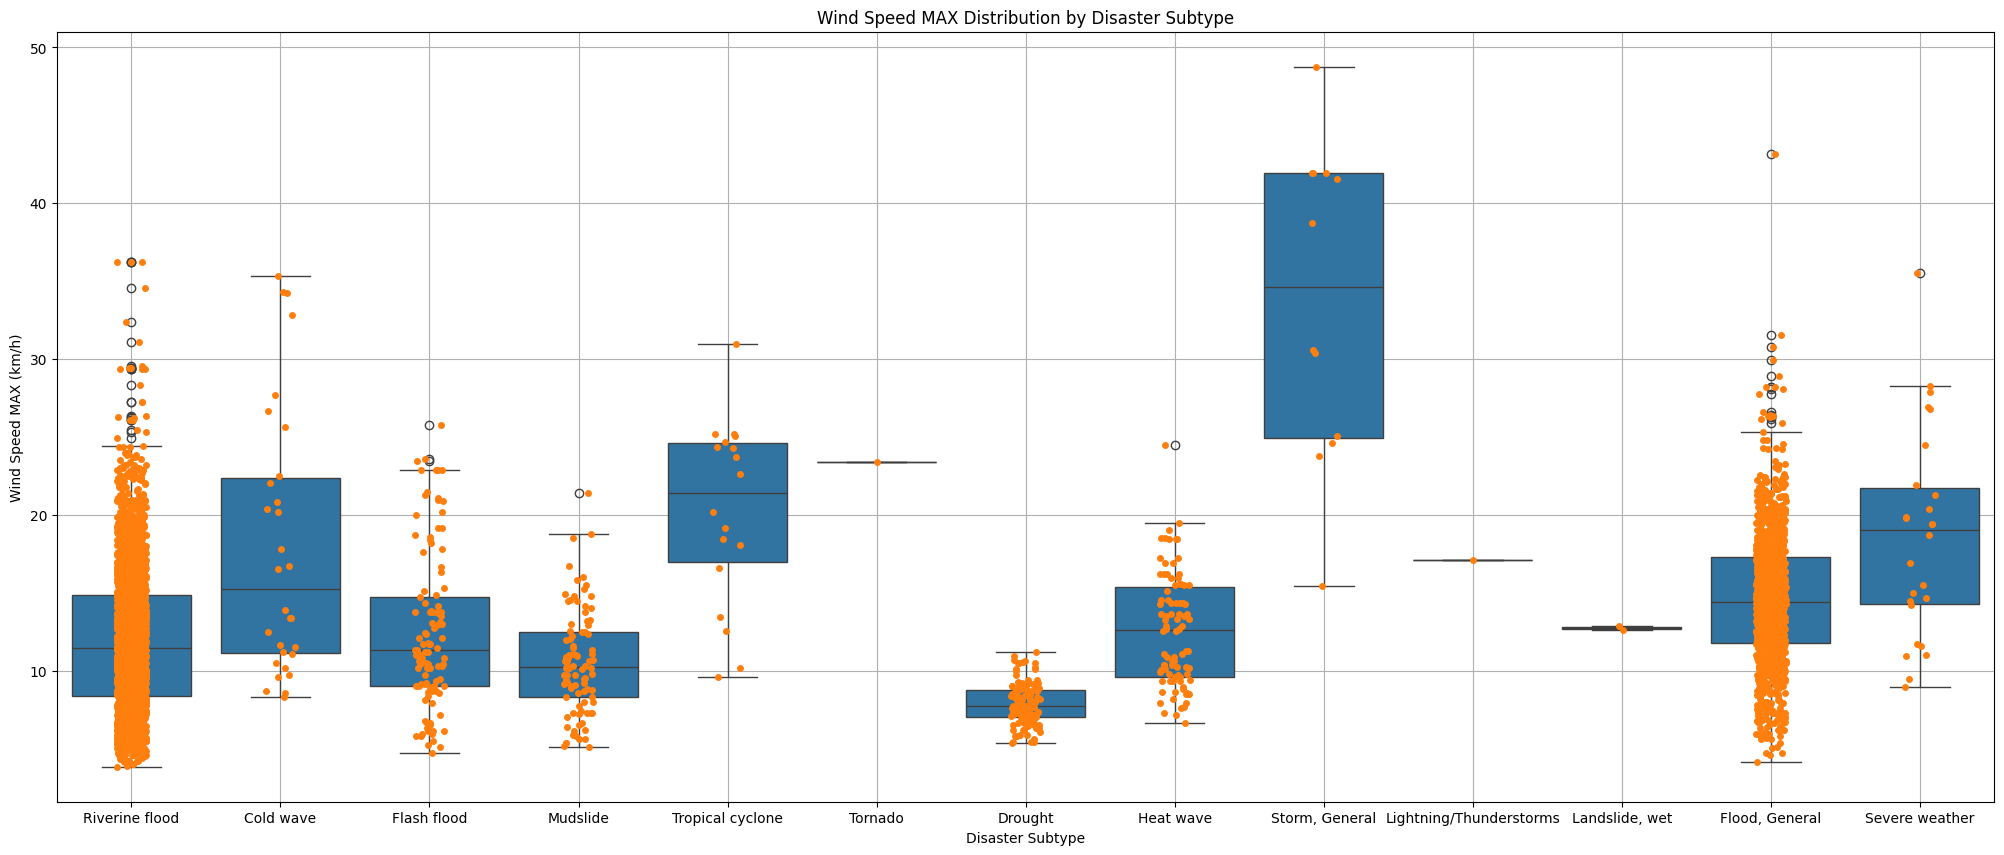

In [149]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="wind_speed_10m_max",
    xlabel="Disaster Subtype",
    ylabel="Wind Speed MAX (km/h)",
    title="Wind Speed MAX Distribution by Disaster Subtype"
    )

> Wind gusts 10m

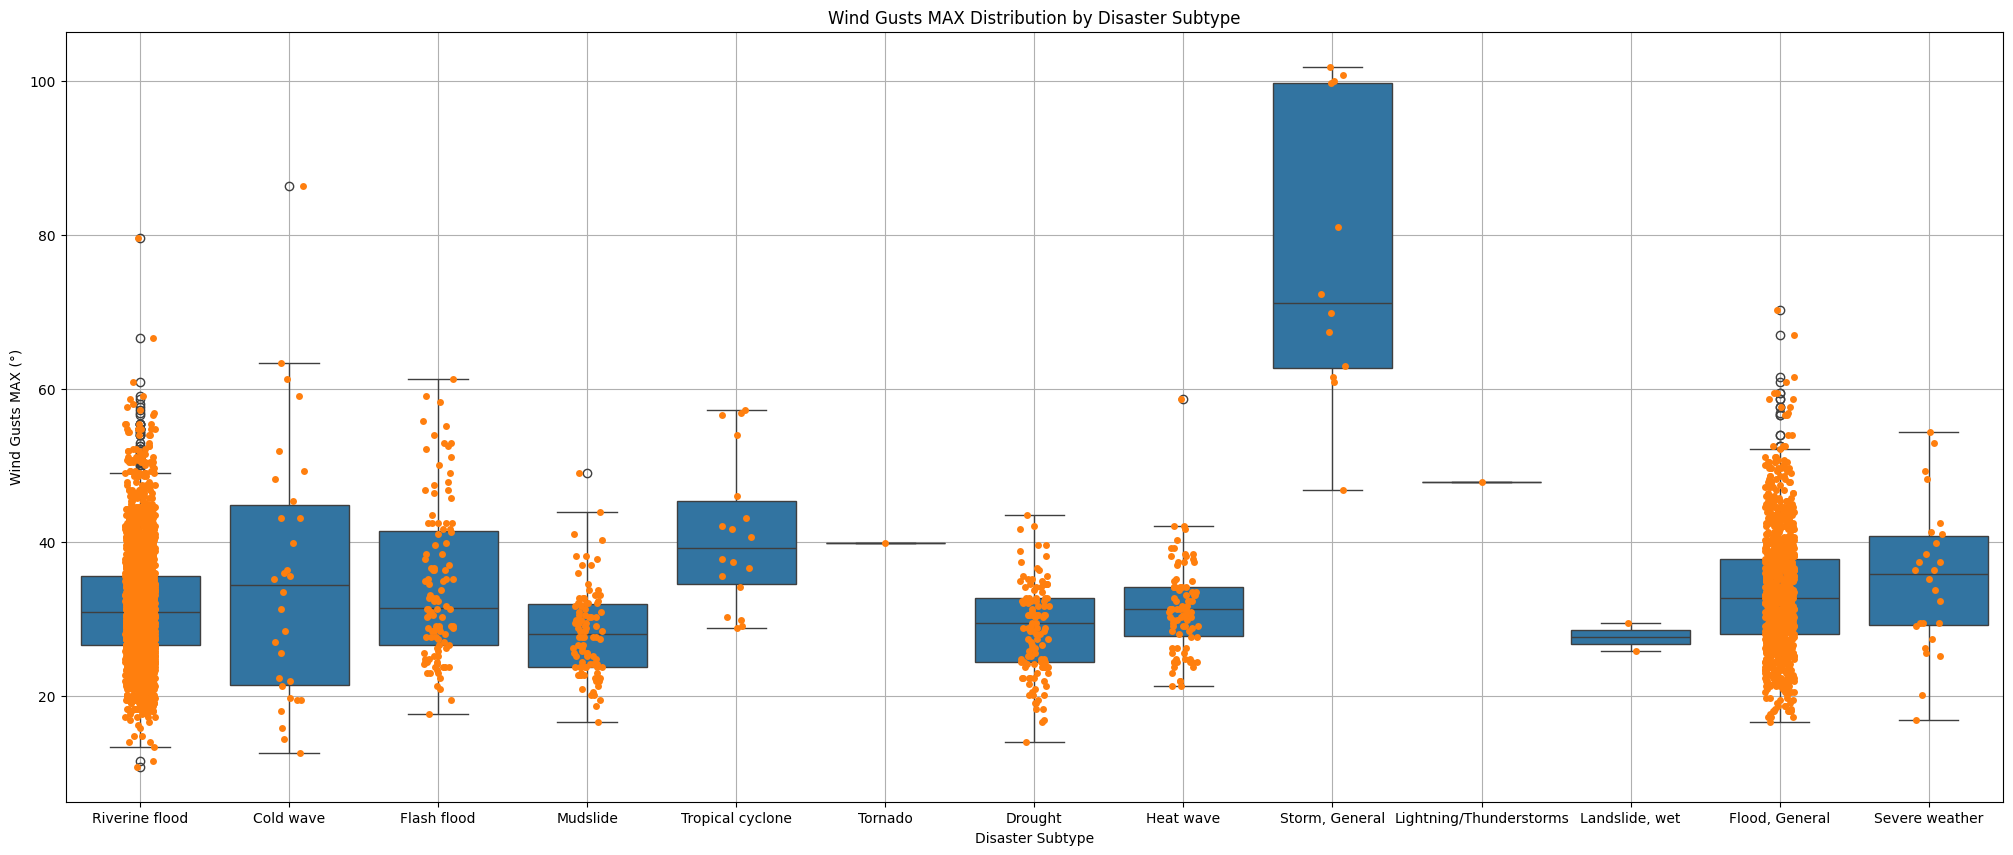

In [150]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="wind_gusts_10m_max",
    xlabel="Disaster Subtype",
    ylabel="Wind Gusts MAX (°)",
    title="Wind Gusts MAX Distribution by Disaster Subtype"
    )

> Wind direction 10m

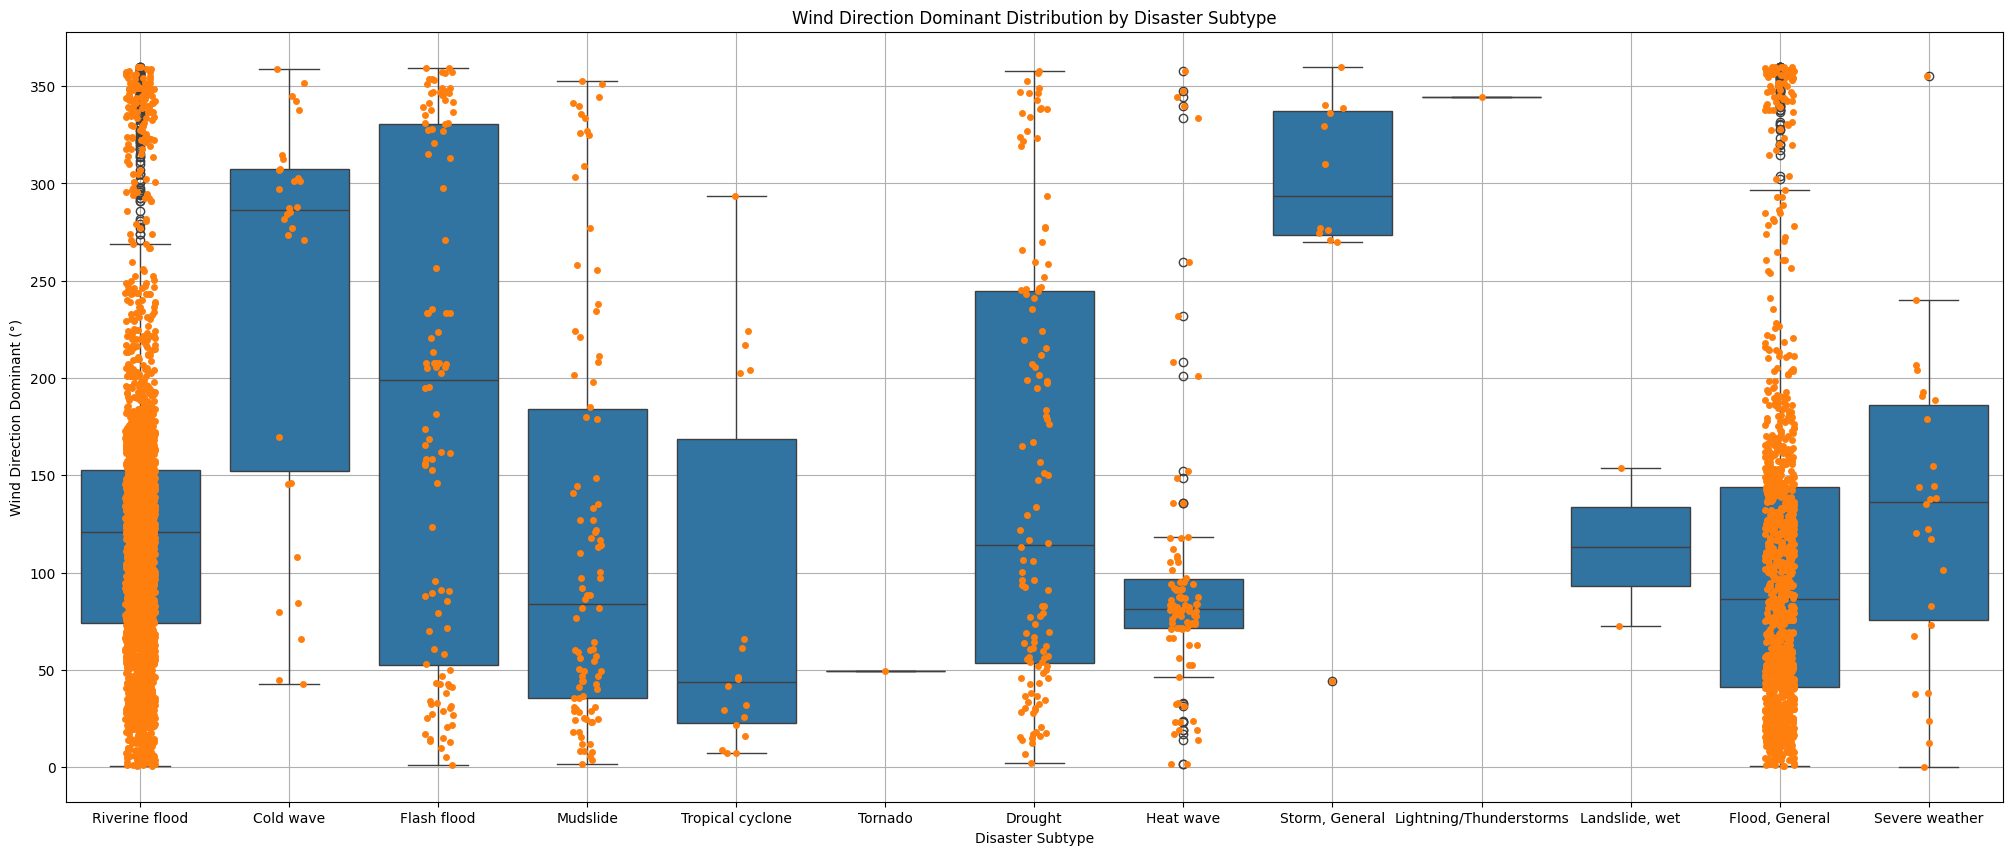

In [151]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="wind_direction_10m_dominant",
    xlabel="Disaster Subtype",
    ylabel="Wind Direction Dominant (°)",
    title="Wind Direction Dominant Distribution by Disaster Subtype"
    )

> Shortware radiation sum

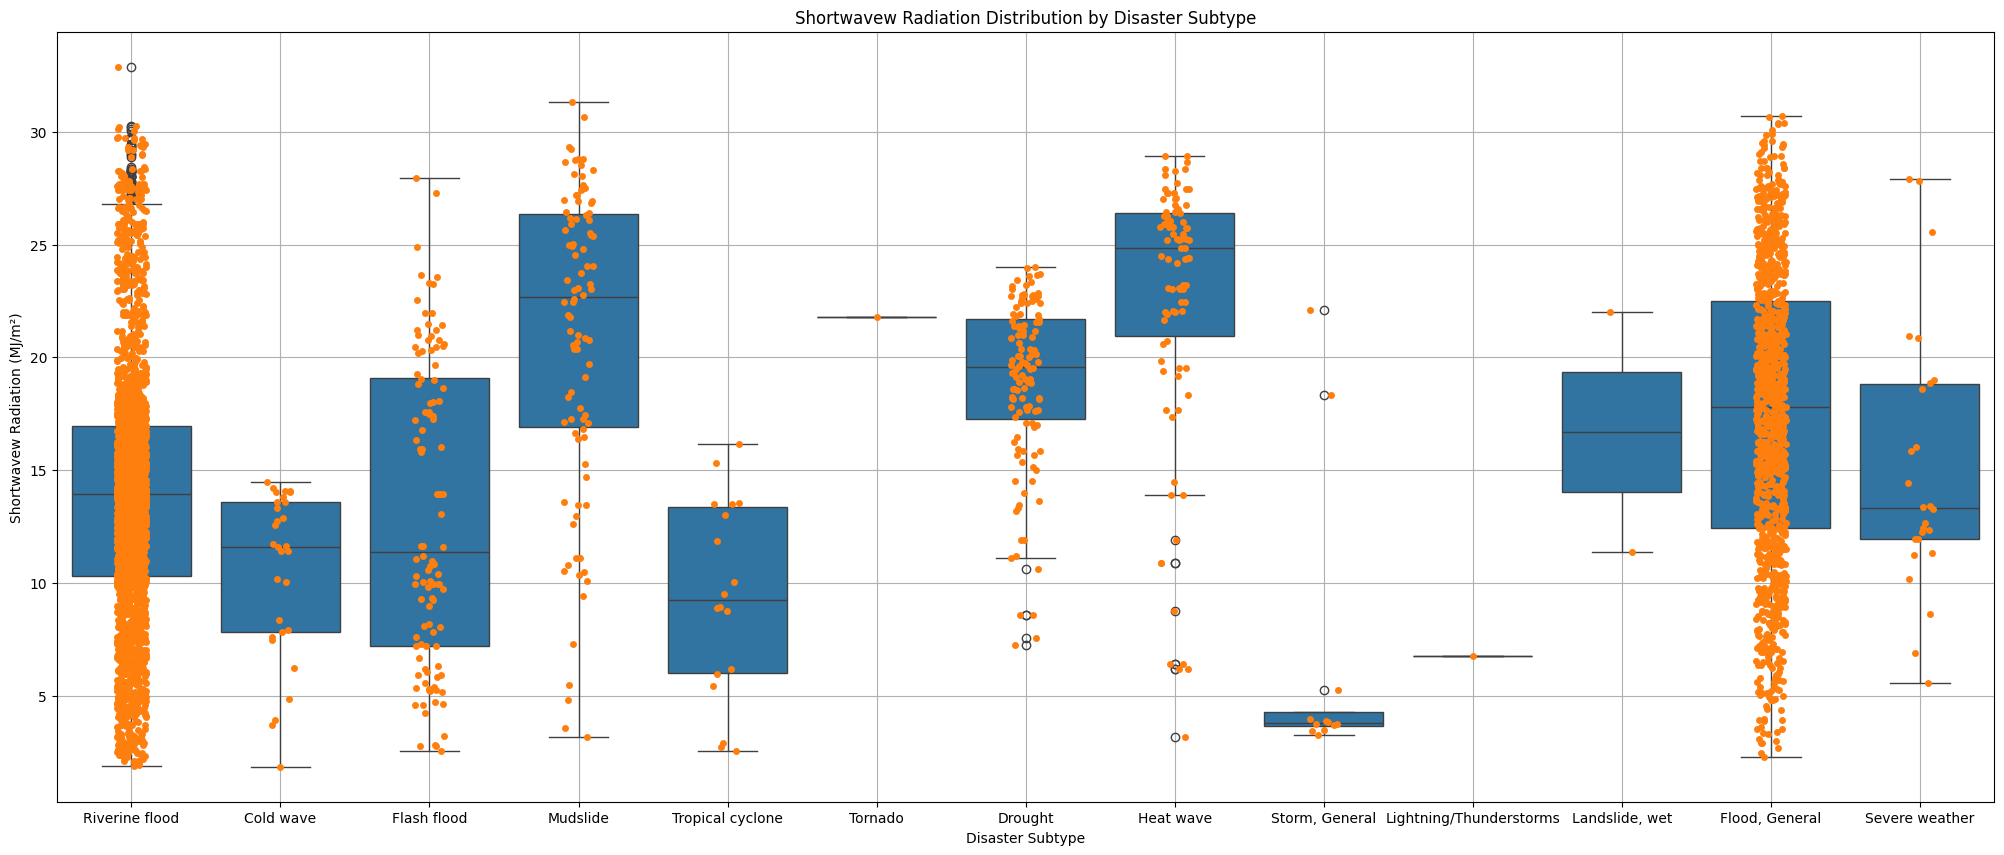

In [153]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="shortwave_radiation_sum",
    xlabel="Disaster Subtype",
    ylabel="Shortwavew Radiation (MJ/m²)",
    title="Shortwavew Radiation Distribution by Disaster Subtype"
    )

> Evapotranspiration

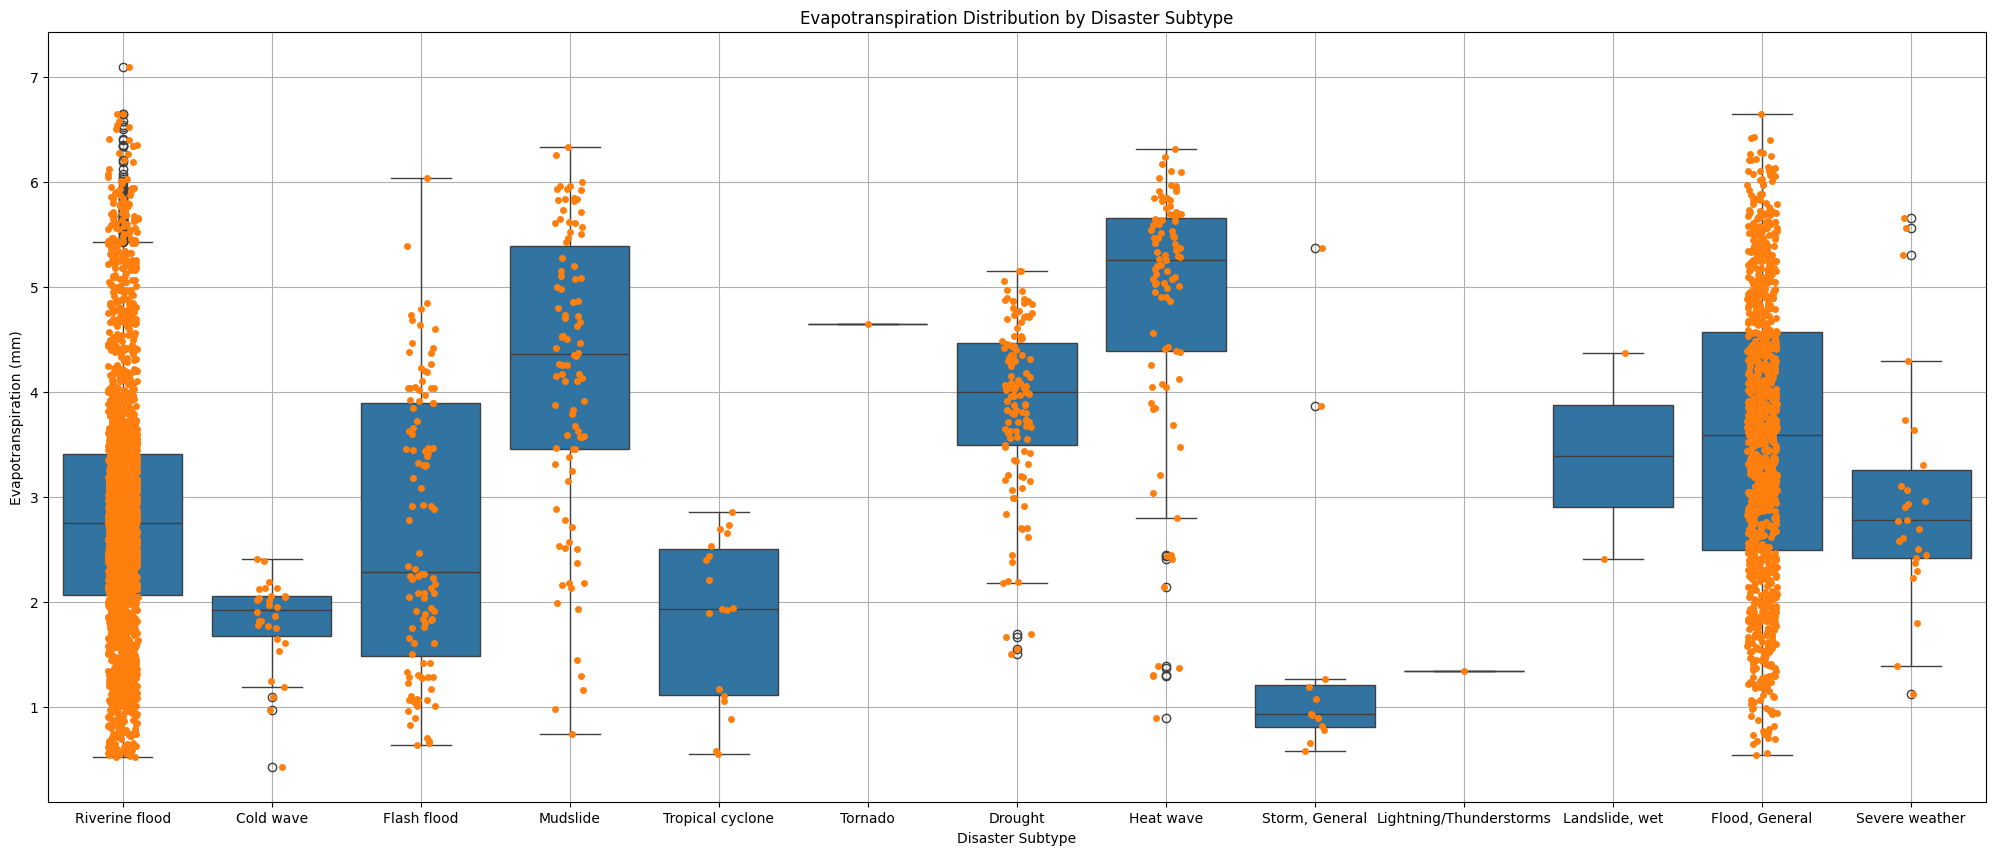

In [154]:
generate_bsplot(
    dataFrame=df_gen,
    xv="disaster_subtype",
    yv="et0_fao_evapotranspiration",
    xlabel="Disaster Subtype",
    ylabel="Evapotranspiration (mm)",
    title="Evapotranspiration Distribution by Disaster Subtype"
    )